In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import numpy as np
import pandas as pd
import tensorflow as tf

import gc
import time
import pickle
import random
import re 
import argparse
import h5py
pd.options.display.max_columns = None
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from scipy.stats import mode

#from utils import *

## Maximum greed library
from joblib import Parallel, delayed
import multiprocessing
from multiprocessing import Pool

/home/bsong/venv/mercari/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
dat_ = pd.read_csv('/home/bsong/test_run2/steve_jobs_mode/csv_dat/ul_010118_022218.csv',engine = 'python')
print(dat_.shape)
dat_.head(20)

In [ ]:
dat_newer = pd.read_csv('/home/bsong/test_run2/steve_jobs_mode/csv_dat/ul_04252018.csv', engine='python')
print(dat_newer.shape)
dat_newer.head()

In [ ]:
dat_3mil = pd.concat([dat_, dat_newer], axis = 0)
dat_3mil.shape

In [ ]:
dat_3mil.to_csv('/home/bsong/test_run2/steve_jobs_mode/csv_dat/newest_update.csv',index =False)

In [2]:
with open('/home/bsong/test_run2/steve_jobs_mode/working_directory/lookup_tables/fulldat.pkl','rb') as picklin: 
    dat_ = pickle.load(picklin, encoding='latin')
#dat_ = pd.read_csv('/home/bsong/test_run2/steve_jobs_mode/dat_partially_cleaned.csv')
#dat_.drop('Unnamed: 0', axis =1, inplace=True)

dat_.MAX_AGE_OF_CAR = dat_.MAX_AGE_OF_CAR.values.astype(float)
dat_.NORMALIZED_TRANSMISSION.fillna('missing',inplace=True)
dat_['MAKE_MODEL'] = dat_['MAKE'] + ' ' + dat_['MODEL']
print(dat_.shape)
dat_.head()


(3461791, 59)


,VIN,CITY,STATE,ZIPCODE,LATITUDE,LONGITUDE,LISTING_ID,YEAR,MAKE,MODEL,PRICE,MILEAGE,EXTERIOR_COLOR_NAME,DATE_CREATED,DATE_UPDATED,DATE_SOLD,SOLD,LEATHER,NAVIGATION,FREE_VEHICLE_REPORT_AVAILABLE,CARFAX_ONE_OWNER,NORMALIZED_TRANSMISSION,EXPECTED_PRICE,CERTIFIED,ACODE,COUNTY,Year_bin,Mileage_bins,DealerNet,MSRP,EPA,DestinationCharge,Holdback,RealTrim,VarDesc,Wheelbase,VehSegment,LOCATION,MODEL_TRIM,FULL_CAR,FULL_CAR_W_TRIM,MAKE_MODEL,MAX_AGE_OF_CAR,AGE_OF_CAR,Premium_Package_Flag,Tow_Package_Flag,Technology_Package_Flag,Convenience_Package_Flag,Towing_Preparation_Package_Flag,Sport_Package_Flag,Towing_Package_Flag,Driver_Assistance_Package_Flag,Alloy_Wheels_Flag,Steel_Wheels_Flag,Chrome_Wheels_Flag,Premium_Wheels_Flag,Bluetooth_Flag,Camera_Flag,Aluminum_Flag
0,3VW217AUXFM081835,anaheim,ca,92807,33.8505,-117.7911,1.689351e+09,2015,volkswagen,golf,11199.0,55000.0,black,2018/01/01 08:01:49.000,2018/01/18 11:54:39.000,NaN,0.0,1.0,0.0,0.0,0.0,A,NaN,0.0,USC50VWC022A0,orange county,2015,50000-60000,19735.10,20995.0,compact cars,820.0,419.9,tsi s 4-door,4dr front-wheel drive hatchback,103.8,compact,"Anaheim, CA",Golf TSI S 4-Door,2015 Volkswagen Golf,2015 Volkswagen Golf TSI S 4-Door,volkswagen golf,2018.0,3.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,WAUGL68E45A51,whittier,ca,90605,33.9454,-118.0336,1.689351e+09,2005,audi,s4,9900.0,73304.0,black,2018/01/01 11:05:49.000,2018/01/03 06:19:56.000,NaN,0.0,0.0,0.0,0.0,0.0,A,NaN,0.0,USB50AUC084A0,los angeles county,2005,70000-80000,42485.00,46100.0,compact cars,720.0,0.0,4.2,4dr all-wheel drive quattro sedan,104.3,luxury sport,"Whittier, CA",S4 4.2,2005 Audi S4,2005 Audi S4 4.2,audi s4,2018.0,13.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,JN1AZ36A05M75,whittier,ca,90605,33.9454,-118.0336,1.689351e+09,2005,nissan,350z,6990.0,91907.0,silver,2018/01/01 11:08:20.000,2018/01/03 06:19:56.000,NaN,0.0,0.0,0.0,0.0,0.0,M,NaN,0.0,USB50NIC092A0,los angeles county,2005,90000-100000,30904.20,34450.0,two-seaters,580.0,955.8,enthusiast,2dr roadster,104.3,luxury sport,"Whittier, CA",350Z Enthusiast,2005 Nissan 350Z,2005 Nissan 350Z Enthusiast,nissan 350z,2009.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,3GYFNAEY6BS588198,chandler,az,85286,33.2754,-111.8634,1.689351e+09,2011,cadillac,srx,16750.0,65100.0,white diamond pearl,2018/01/01 20:24:39.000,2018/01/03 14:05:05.000,NaN,0.0,1.0,0.0,0.0,0.0,A,15742.0,0.0,USC10CAS041B0,maricopa county,2011,60000-70000,35726.18,39045.0,small sport utility vehicles 2wd,875.0,1171.35,luxury collection,4dr front-wheel drive,110.5,luxury sport utility,"Chandler, AZ",SRX Luxury Collection,2011 Cadillac SRX,2011 Cadillac SRX Luxury Collection,cadillac srx,2016.0,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,JNRAS08U26X106293,phoenix,az,85023,33.639496,-112.08588700000001,1.689351e+09,2006,infiniti,fx35,8499.0,110028.0,not given,2018/01/02 08:21:34.000,2018/01/12 13:03:51.000,2018/01/12 13:03:13.000,1.0,0.0,0.0,0.0,0.0,A,NaN,0.0,USB60INS071A0,maricopa county,2006,110000-120000,33677.00,37800.0,2wd sport utility vehicles,700.0,1073.0,base,4dr 4x2,112.2,luxury sport utility,"Phoenix, AZ",FX35 Base,2006 INFINITI FX35,2006 INFINITI FX35 Base,infiniti fx35,2012.0,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [16]:
just_camry_le = dat_[(dat_.MAKE_MODEL == 'toyota camry') & (dat_.RealTrim == 'le')].copy()
Counter(just_camry_le.MSRP.values).most_common()

[(23070.0, 20717),
 (22970.0, 14071),
 (24000.0, 2961),
 (19295.0, 480),
 (19875.0, 346),
 (19045.0, 342),
 (18970.0, 231),
 (26790.0, 63),
 (26140.0, 29),
 (25990.0, 18),
 (22448.0, 11),
 (27800.0, 9),
 (17498.0, 7),
 (18088.0, 3),
 (20968.0, 1)]

In [18]:
small_bit = just_camry_le[['VIN','ACODE','FULL_CAR_W_TRIM','CITY','STATE','MSRP','PRICE']][just_camry_le.ACODE == 'USC80TOC021A0'].copy()

In [19]:
small_bit.to_csv('/home/bsong/camry_le_wrong_acode.csv',index = False)

In [ ]:
dat_[(dat_.MAKE_MODEL == 'toyota camry') & (dat_.RealTrim == 'se')].sort_values('YEAR', ascending = False).shape

In [ ]:
def get_fairprice(dat_, zipdict_, year_, make_, model_, trim_, mileage_, zipcode_):
    cond_year = (dat_.YEAR == year_)
    cond_make = (dat_.MAKE == make_)
    cond_model = (dat_.MODEL == model_)
    
    if trim_ != 'idk':
        cond_trim_ = (dat_.RealTrim == trim_)
    else:
        cond_trim_ = True
    dat_ = dat_[cond_year & cond_make & cond_model & cond_trim_]#
    print('typical mileage: median:' + str(np.median(dat_.MILEAGE.values)) + ' | mean: ' + str(np.mean(dat_.MILEAGE.values)))
    if mileage_ != 'all':
        cond_mileage = ((mileage_ - 10000 < dat_.MILEAGE) & (dat_.MILEAGE > mileage_ + 10000) )
        dat_temp = dat_[cond_mileage].copy()
        if dat_temp.shape[0] > 5:
            dat_ = dat_temp
    _, inds_to_consider = filter_by_longlat(dat_, zipdict_['LONGITUDE'][zipcode_], zipdict_['LATITUDE'][zipcode_], 100)
    if len(inds_to_consider):
        dat_ = dat_.iloc[inds_to_consider,]
    
    
    sorted_price = sorted(dat_.PRICE.values)
    median_price = np.median(sorted_price)
    low_ = round(len(sorted_price)*.175)
    upp_ = round(len(sorted_price)*.825)
    print(' ')
    
    low_price = sorted_price[low_]
    upp_price = sorted_price[upp_]
    print('range: ' + str(low_price) + '-' + str(upp_price))
    
    print(' ')
    print('total cars: ' + str(dat_.shape[0]))
    print(' ')
    print_dat = dat_[['CITY','STATE','FULL_CAR_W_TRIM','PRICE','MILEAGE']]
    
    print(print_dat.to_string(index=False))

In [ ]:
get_fairprice(dat_,zipdict, 2015,'toyota','camry','le',47784,90703)

In [2]:
def add_datepart(df, fldname, drop=True, time=False):
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.

    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    time: If true time features: Hour, Minute, Second will be added.

    """
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)


def train_cats(df):
    """Change any columns of strings in a panda's dataframe to a column of
    catagorical values. This applies the changes inplace.

    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values.

    """
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()


def proc_df(df, cat_dict, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe.

    Parameters:
    -----------
    df: The data frame you wish to process.

    y_fld: The name of the response variable

    skip_flds: A list of fields that dropped from df.

    ignore_flds: A list of fields that are ignored during processing.

    do_scale: Standardizes each column in df. Takes Boolean Values(True,False)

    na_dict: a dictionary of na columns to add. Na columns are also added if there
        are any missing values.

    preproc_fn: A function that gets applied to df.

    max_n_cat: The maximum number of categories to break into dummy values, instead
        of integer codes.

    subset: Takes a random subset of size subset from df.

    mapper: If do_scale is set as True, the mapper variable
        calculates the values used for scaling of variables during training time (mean and standard deviation).

    Returns:
    --------
    [x, y, nas, mapper(optional)]:

        x: x is the transformed version of df. x will not have the response variable
            and is entirely numeric.

        y: y is the response variable

        nas: returns a dictionary of which nas it created, and the associated median.

        mapper: A DataFrameMapper which stores the mean and standard deviation of the corresponding continuous
        variables which is then used for scaling of during test-time.

     """
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    df = df.copy()
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat, cat_dict)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def fix_missing(df, col, name, na_dict):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.

    Parameters:
    -----------
    df: The data frame that will be changed.

    col: The column of data to fix by filling in missing data.

    name: The name of the new filled column in df.

    na_dict: A dictionary of values to create na's of and the value to insert. If
        name is not a key of na_dict the median will fill any missing data. Also
        if name is not a key of na_dict and there is no missing data in col, then
        no {name}_na column is not created.

    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name, max_n_cat, cat_dict):
    """ Changes the column col from a categorical type to it's integer codes.

    Parameters:
    -----------
    df: A pandas dataframe. df[name] will be filled with the integer codes from
        col.

    col: The column you wish to change into the categories.
    name: The column name you wish to insert into df. This column will hold the
        integer codes.

    max_n_cat: If col has more categories than max_n_cat it will not change the
        it to its integer codes. If max_n_cat is None, then col will always be
        converted.
    """
    if not is_numeric_dtype(col) and ( max_n_cat is None or col.nunique()>max_n_cat):
        col_keep = col.copy()
        df[name] = col.cat.codes+1
        #if name == 'MAKE_MODEL': # lol. only do for MAKE_MODEL. 
        #    new_pd = pd.DataFrame({'names':col_keep.values, 'inds':df[name].values})
        #    asdf_dict = {name:{row['inds']:row['names'] for _, row in new_pd.iterrows()}}
        #    cat_dict.update(asdf_dict)

def scale_vars(df, mapper):
    warnings.filterwarnings('ignore', category=sklearn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n],StandardScaler()) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

def split_vals(a,n): 
    return a[:n].copy(), a[n:].copy()

def MAE_(preds, reals):
    return np.mean(np.abs(preds - reals))
def RMSE_(preds, reals):
    return np.sqrt(np.mean(np.square(preds - reals)))

In [ ]:
#1545 models

pt_models = dat_.pivot_table(index= ['MAKE','MODEL'], values='VIN',aggfunc='count')
print(pt_models)
count_models = np.squeeze(pt_models.values)

plt.plot(sorted(count_models))
print(sorted(count_models))
plt.show()

In [ ]:
# run all the make/model combinations individually

def run_rf_and_stuff(dat_rf, name_make_model):
    dat_rf = dat_rf[dat_rf.MAKE_MODEL == name_make_model]
    dat_rf.drop(['MAKE','MAKE_MODEL'], axis = 1) # only one class in each so useless
    rf = RandomForestRegressor(n_estimators = 32, n_jobs=16, verbose= 1)

    dat_rf['DATE_CREATED'] = pd.to_datetime(dat_rf['DATE_CREATED'],format = '%Y/%m/%d %H:%M:%S')
    dat_rf = dat_rf.sort_values('DATE_CREATED')
    #print(dat_rf.head())
    #dat_rf.NORMALIZED_TRANSMISSION.fillna('missing',inplace=True)
    #string_cols = ['CITY','STATE','MAKE','MODEL','NORMALIZED_TRANSMISSION','EPA','RealTrim','MODEL_TRIM']
    add_datepart(dat_rf, 'DATE_CREATED')
    train_cats(dat_rf)

    cat_dict={}
    df, y, nas_ = proc_df(dat_rf, cat_dict,'PRICE')

    n_valid = round(dat_rf.shape[0]*.2)
    n_trn = len(df)-n_valid
    raw_train, raw_valid = split_vals(dat_rf, n_trn)
    X_train, X_valid = split_vals(df, n_trn)
    y_train, y_valid = split_vals(y, n_trn)

    #print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)
    #print(X_train.isnull().sum())
    #print(X_train.head())
    rf.fit(X_train, y_train)

    preds = rf.predict(X_valid)

    mae_ = MAE_(preds, y_valid)
    #print('MAE: ' + str(mae_))
    rmse_ = RMSE_(preds, y_valid)
    #print("RMSE: " + str(rmse_))
    #result_df = pd.DataFrame({'pred':preds, 'true':y_valid})
    #result_df.head(50)
    count_ = X_valid.shape[0]
    return name_make_model, mae_, rmse_, count_

In [44]:
unique_MAKE_MODEL = np.unique(dat_rf.MAKE_MODEL) #['ford f-150']
df_results_individual = pd.DataFrame(columns=['NAME', 'MAE', 'RMSE','COUNT'])
for i in range(len(unique_MAKE_MODEL)):
    make_model_trial = unique_MAKE_MODEL[i]
    dat_chunk = dat_rf[dat_rf.MAKE_MODEL == make_model_trial].copy()
    if dat_chunk.shape[0] > 100:
        tuple_trial = run_rf_and_stuff(dat_chunk, make_model_trial)
        df_results_individual.loc[i] = list(tuple_trial)
    else:
        return_junk = [make_model_trial, 999999, 999999, 999999]
        df_results_individual.loc[i] = return_junk
    #print(make_model_trial)


NameError: name 'run_rf_and_stuff' is not defined

In [3]:
with open('/home/bsong/all_vin_dict.pkl','rb') as pickle_in:
    all_vin_dict = pickle.load(pickle_in)

all_vin_df = pd.DataFrame(all_vin_dict)
print(all_vin_df.shape)
all_vin_df = all_vin_df.transpose()
print(all_vin_df.shape)

(18, 2022011)
(2022011, 18)


In [4]:
all_vin_df.head()

,AccidentIndicators,AccidentIndicatorsText,AirbagDeployment,AirbagDeploymentText,BBG,BBGText,FrameDamage,FrameDamageText,ManufacturerRecall,ManufacturerRecallText,OdometerRollback,OdometerRollbackText,Ownership,OwnershipText,TotalLoss,TotalLossText,Vehicle-Specifications,WindowSticker
00000000000A10120,None,No Accidents / Damage Reported to CARFAX,None,No Airbag Deployment Reported to CARFAX,None,Vehicle Qualifies for the CARFAX Buyback Guara...,None,No Structural/Frame Damage Reported to CARFAX,None,No Manufacturer Recalls Reported to CARFAX,None,No Indication of an Odometer Rollback,None,None,None,No Total Loss Reported to CARFAX,None,None
00000000000B5118A,None,No Accidents / Damage Reported to CARFAX,None,No Airbag Deployment Reported to CARFAX,None,Vehicle Qualifies for the CARFAX Buyback Guara...,None,No Structural/Frame Damage Reported to CARFAX,None,No Manufacturer Recalls Reported to CARFAX,None,No Indication of an Odometer Rollback,None,None,None,No Total Loss Reported to CARFAX,None,None
0000000000CC7771L,None,No Accidents / Damage Reported to CARFAX,None,No Airbag Deployment Reported to CARFAX,None,Vehicle Qualifies for the CARFAX Buyback Guara...,None,No Structural/Frame Damage Reported to CARFAX,None,No Manufacturer Recalls Reported to CARFAX,None,No Indication of an Odometer Rollback,None,None,None,No Total Loss Reported to CARFAX,None,None
0000000000KY13507,None,No Accidents / Damage Reported to CARFAX,None,No Airbag Deployment Reported to CARFAX,None,Vehicle Qualifies for the CARFAX Buyback Guara...,None,No Structural/Frame Damage Reported to CARFAX,None,No Manufacturer Recalls Reported to CARFAX,None,No Indication of an Odometer Rollback,None,None,None,No Total Loss Reported to CARFAX,None,None
000000000I2510512,None,No Accidents / Damage Reported to CARFAX,None,No Airbag Deployment Reported to CARFAX,None,Vehicle Qualifies for the CARFAX Buyback Guara...,None,No Structural/Frame Damage Reported to CARFAX,None,No Manufacturer Recalls Reported to CARFAX,None,No Indication of an Odometer Rollback,None,None,None,No Total Loss Reported to CARFAX,None,None


In [5]:
asdf = all_vin_df.reset_index()
asdf.rename(columns={'index':'VIN'}, inplace = True)
n_owner_dict = pd.Series(asdf.OwnershipText.values, index = asdf.VIN.values).to_dict()
dat_['CFX_N_OWNERS'] = dat_.VIN.map(n_owner_dict)
dat_.CFX_N_OWNERS.fillna('missing',inplace =True)

In [6]:
dat_.head()

,VIN,CITY,STATE,ZIPCODE,LATITUDE,LONGITUDE,LISTING_ID,YEAR,MAKE,MODEL,PRICE,MILEAGE,EXTERIOR_COLOR_NAME,DATE_CREATED,DATE_UPDATED,DATE_SOLD,SOLD,LEATHER,NAVIGATION,FREE_VEHICLE_REPORT_AVAILABLE,CARFAX_ONE_OWNER,NORMALIZED_TRANSMISSION,EXPECTED_PRICE,CERTIFIED,ACODE,COUNTY,Year_bin,Mileage_bins,DealerNet,MSRP,EPA,DestinationCharge,Holdback,RealTrim,VarDesc,Wheelbase,VehSegment,LOCATION,MODEL_TRIM,FULL_CAR,FULL_CAR_W_TRIM,MAKE_MODEL,MAX_AGE_OF_CAR,AGE_OF_CAR,Premium_Package_Flag,Tow_Package_Flag,Technology_Package_Flag,Convenience_Package_Flag,Towing_Preparation_Package_Flag,Sport_Package_Flag,Towing_Package_Flag,Driver_Assistance_Package_Flag,Alloy_Wheels_Flag,Steel_Wheels_Flag,Chrome_Wheels_Flag,Premium_Wheels_Flag,Bluetooth_Flag,Camera_Flag,Aluminum_Flag,CFX_N_OWNERS
0,3VW217AUXFM081835,anaheim,ca,92807,33.8505,-117.7911,1.689351e+09,2015,volkswagen,golf,11199.0,55000.0,black,2018/01/01 08:01:49.000,2018/01/18 11:54:39.000,NaN,0.0,1.0,0.0,0.0,0.0,A,NaN,0.0,USC50VWC022A0,orange county,2015,50000-60000,19735.10,20995.0,compact cars,820.0,419.9,tsi s 4-door,4dr front-wheel drive hatchback,103.8,compact,"Anaheim, CA",Golf TSI S 4-Door,2015 Volkswagen Golf,2015 Volkswagen Golf TSI S 4-Door,volkswagen golf,2018.0,3.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,missing
2,WAUGL68E45A51,whittier,ca,90605,33.9454,-118.0336,1.689351e+09,2005,audi,s4,9900.0,73304.0,black,2018/01/01 11:05:49.000,2018/01/03 06:19:56.000,NaN,0.0,0.0,0.0,0.0,0.0,A,NaN,0.0,USB50AUC084A0,los angeles county,2005,70000-80000,42485.00,46100.0,compact cars,720.0,0.0,4.2,4dr all-wheel drive quattro sedan,104.3,luxury sport,"Whittier, CA",S4 4.2,2005 Audi S4,2005 Audi S4 4.2,audi s4,2018.0,13.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,missing
3,JN1AZ36A05M75,whittier,ca,90605,33.9454,-118.0336,1.689351e+09,2005,nissan,350z,6990.0,91907.0,silver,2018/01/01 11:08:20.000,2018/01/03 06:19:56.000,NaN,0.0,0.0,0.0,0.0,0.0,M,NaN,0.0,USB50NIC092A0,los angeles county,2005,90000-100000,30904.20,34450.0,two-seaters,580.0,955.8,enthusiast,2dr roadster,104.3,luxury sport,"Whittier, CA",350Z Enthusiast,2005 Nissan 350Z,2005 Nissan 350Z Enthusiast,nissan 350z,2009.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,missing
5,3GYFNAEY6BS588198,chandler,az,85286,33.2754,-111.8634,1.689351e+09,2011,cadillac,srx,16750.0,65100.0,white diamond pearl,2018/01/01 20:24:39.000,2018/01/03 14:05:05.000,NaN,0.0,1.0,0.0,0.0,0.0,A,15742.0,0.0,USC10CAS041B0,maricopa county,2011,60000-70000,35726.18,39045.0,small sport utility vehicles 2wd,875.0,1171.35,luxury collection,4dr front-wheel drive,110.5,luxury sport utility,"Chandler, AZ",SRX Luxury Collection,2011 Cadillac SRX,2011 Cadillac SRX Luxury Collection,cadillac srx,2016.0,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,missing
6,JNRAS08U26X106293,phoenix,az,85023,33.639496,-112.08588700000001,1.689351e+09,2006,infiniti,fx35,8499.0,110028.0,not given,2018/01/02 08:21:34.000,2018/01/12 13:03:51.000,2018/01/12 13:03:13.000,1.0,0.0,0.0,0.0,0.0,A,NaN,0.0,USB60INS071A0,maricopa county,2006,110000-120000,33677.00,37800.0,2wd sport utility vehicles,700.0,1073.0,base,4dr 4x2,112.2,luxury sport utility,"Phoenix, AZ",FX35 Base,2006 INFINITI FX35,2006 INFINITI FX35 Base,infiniti fx35,2012.0,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,missing


In [7]:
dat_rf = dat_[['LISTING_ID','COUNTY','LATITUDE','LONGITUDE','YEAR','MAKE','MAKE_MODEL','PRICE','MILEAGE',
               'DATE_CREATED','MODEL_TRIM', 'CERTIFIED',
               'MSRP','EPA','DestinationCharge','RealTrim', 'VehSegment', 'VarDesc','AGE_OF_CAR','VIN','CFX_N_OWNERS'
                ,'Premium_Package_Flag','Tow_Package_Flag','Technology_Package_Flag',
               'Convenience_Package_Flag','Towing_Preparation_Package_Flag','Sport_Package_Flag',
               'Towing_Package_Flag','Driver_Assistance_Package_Flag',
               'Alloy_Wheels_Flag','Steel_Wheels_Flag','Chrome_Wheels_Flag','Premium_Wheels_Flag','Bluetooth_Flag','Camera_Flag',
               'Aluminum_Flag'
]].copy() #'CITY','STATE','ZIPCODE','LEATHER','NAVIGATION','EXTERIOR_COLOR_NAME','DealerNet','CERTIFIED','NORMALIZED_TRANSMISSION',
#'Cold_Weather_Package_Flag','Heavy-Duty_Handling/Trailering_Suspension_Package_Flag',
# to keep it simple
del dat_

#dat_rf = dat_rf[['COUNTY','MAKE','MAKE_MODEL','RealTrim','YEAR','PRICE','MILEAGE','MSRP','AGE_OF_CAR','DATE_CREATED'
#                ,'NORMALIZED_TRANSMISSION','CERTIFIED']]#,
               #'Alloy_Wheels_Flag','Steel_Wheels_Flag','Chrome_Wheels_Flag','Premium_Wheels_Flag','Bluetooth_Flag','Camera_Flag',
               #'Aluminum_Flag']] #'Premium_Package_Flag','Tow_Package_Flag','Cold_Weather_Package_Flag','Technology_Package_Flag',
               #'Convenience_Package_Flag','Towing_Preparation_Package_Flag','Sport_Package_Flag',
               #'Heavy-Duty_Handling/Trailering_Suspension_Package_Flag','Towing_Package_Flag','Driver_Assistance_Package_Flag',
##
acceptable_makes = ['acura','chrysler','honda','lexus','porsche','alfa romeo','dodge','hyundai','lincoln','ram',
                    'audi','ferrari','infiniti','mazda','subaru','bmw','fiat','jaguar','mercedes-benz','tesla','buick',
                    'ford','jeep','mini','toyota','cadillac','genesis','kia','mitsubishi','volkswagen','chevrolet',
                    'gmc','land rover','nissan','volvo']
print(dat_rf.shape)
dat_rf = dat_rf[dat_rf.MAKE.astype(str).isin(acceptable_makes)]
print(dat_rf.shape)
#dat_rf = dat_rf[dat_rf['MAKE_MODEL'] == 'ford f-150']
#dat_rf.drop(['MAKE','MAKE_MODEL'], axis = 1)
#dat_rf.reset_index(inplace = True)
#dat_rf.drop('LISTING_ID', axis = 1, inplace = True)
#dat_rf['PRICE'] = np.log1p(dat_rf['PRICE'].values)

## testing
'''
dat_rf['Year_bin'] = dat_rf['YEAR'] 
dat_rf['Year_bin'].where(dat_rf['YEAR'] >= 2002, '<2002', inplace = True)
dat_rf['Year_bin'].where(dat_rf['YEAR'] != 2003, '2002-2003', inplace = True)
dat_rf['Year_bin'].where(dat_rf['YEAR'] != 2002, '2002-2003', inplace = True)
dat_rf['Year_bin'].where(dat_rf['YEAR'] != 2019, '2018+', inplace = True)
dat_rf['Year_bin'].where(dat_rf['YEAR'] != 2018, '2018+', inplace = True)
dat_rf.drop('YEAR', axis = 1, inplace= True)
'''
'''
dat_rf['Mileage_bins'] = dat_rf['MILEAGE']
dat_rf['Mileage_bins'].where(dat_rf['MILEAGE'] >= 5000,'<5000', inplace = True)
for i in range(int(300000/5000)):
    dat_rf['Mileage_bins'].where((dat_rf['MILEAGE'] < 5000*i) | (dat_rf['MILEAGE'] >= 5000*(i+1)),
                                 str(i*5000) + '-' + str((i+1)*5000), inplace = True)
dat_rf['Mileage_bins'].where(dat_rf['MILEAGE'] <= 300000, '300000+', inplace = True)
dat_rf.drop('MILEAGE', axis = 1, inplace = True)   
'''
dat_rf['DATE_CREATED'] = pd.to_datetime(dat_rf['DATE_CREATED'],format = '%Y/%m/%d %H:%M:%S')
dat_rf = dat_rf.sort_values('DATE_CREATED')
dat_rf.drop('DATE_CREATED',axis = 1, inplace = True) # keep simple

(3461791, 36)
(3423494, 36)


In [3]:
#pickle.dump(dat_rf,open('/home/bsong/dat_rf.pkl','wb'))
with open('/home/bsong/dat_rf.pkl','rb') as pickle_in:
    dat_rf = pickle.load(pickle_in)

In [4]:
print(dat_rf.shape)
dat_rf.head()

(3423494, 35)


,LISTING_ID,COUNTY,LATITUDE,LONGITUDE,YEAR,MAKE,MAKE_MODEL,PRICE,MILEAGE,MODEL_TRIM,CERTIFIED,MSRP,EPA,DestinationCharge,RealTrim,VehSegment,VarDesc,AGE_OF_CAR,VIN,CFX_N_OWNERS,Premium_Package_Flag,Tow_Package_Flag,Technology_Package_Flag,Convenience_Package_Flag,Towing_Preparation_Package_Flag,Sport_Package_Flag,Towing_Package_Flag,Driver_Assistance_Package_Flag,Alloy_Wheels_Flag,Steel_Wheels_Flag,Chrome_Wheels_Flag,Premium_Wheels_Flag,Bluetooth_Flag,Camera_Flag,Aluminum_Flag
0,1.689351e+09,orange county,33.8505,-117.7911,2015,volkswagen,volkswagen golf,11199.0,55000.0,Golf TSI S 4-Door,0.0,20995.0,compact cars,820.0,tsi s 4-door,compact,4dr front-wheel drive hatchback,3.0,3VW217AUXFM081835,missing,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1.689351e+09,los angeles county,33.9454,-118.0336,2005,audi,audi s4,9900.0,73304.0,S4 4.2,0.0,46100.0,compact cars,720.0,4.2,luxury sport,4dr all-wheel drive quattro sedan,13.0,WAUGL68E45A51,missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.689351e+09,los angeles county,33.9454,-118.0336,2005,nissan,nissan 350z,6990.0,91907.0,350Z Enthusiast,0.0,34450.0,two-seaters,580.0,enthusiast,luxury sport,2dr roadster,4.0,JN1AZ36A05M75,missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1.689351e+09,maricopa county,33.2754,-111.8634,2011,cadillac,cadillac srx,16750.0,65100.0,SRX Luxury Collection,0.0,39045.0,small sport utility vehicles 2wd,875.0,luxury collection,luxury sport utility,4dr front-wheel drive,5.0,3GYFNAEY6BS588198,missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14,1.689351e+09,maricopa county,33.639496,-112.08588700000001,2008,bmw,bmw 5 series,8298.0,126674.0,5 Series xi,0.0,46800.0,mid-size cars,825.0,xi,luxury high,4dr all-wheel drive sedan,10.0,WBANV13558C150620,missing,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [ ]:
ford_f150 = dat_rf[(dat_rf.MAKE_MODEL == 'ford f-150') & (dat_rf.RealTrim == 'xl') & (dat_rf.VarDesc == '4x4 supercrew cab styleside 5.5 ft. box 145 in. wb')].copy()
print(ford_f150.shape)
ford_f150.head()

In [ ]:
import gmplot 

lat = np.round(ford_f150.LATITUDE.astype(float).values, 1)
long = np.round(ford_f150.LONGITUDE.astype(float).values, 1)
count = ford_f150.PRICE.values
#plt.scatter(lat, long, c=count)
#plt.colorbar()
#plt.show()

gmap = gmplot.GoogleMapPlotter(34.0522, -118.2437, 10)

# Overlay our datapoints onto the map
gmap.heatmap(lat, long)
gmap.draw("/home/bsong/my_heatmap.html")

In [5]:
#rf = RandomForestRegressor(n_estimators = 32, n_jobs=16, verbose= 1)
rf = RandomForestRegressor(n_estimators = 64, max_features = 0.5, max_depth = 50, n_jobs=-1, verbose= 1) # best gridcross score


#dat_rf.NORMALIZED_TRANSMISSION.fillna('missing',inplace=True)
#string_cols = ['CITY','STATE','MAKE','MODEL','NORMALIZED_TRANSMISSION','EPA','RealTrim','MODEL_TRIM']
#add_datepart(dat_rf, 'DATE_CREATED') # KEEP SIMPLE
train_cats(dat_rf)

cat_dict={}
df, y, nas_ = proc_df(dat_rf, cat_dict,'PRICE')

n_valid = round(dat_rf.shape[0]*.2)
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(dat_rf, n_trn)

drop_some = ['LISTING_ID','MAKE','VIN']#,'DealerNet']
df.drop(drop_some, axis = 1, inplace = True)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape


((2738795, 31), (2738795,), (684699, 31), (684699,))

In [ ]:
dat_rf[(dat_rf.MODEL_TRIM == 'Camry SE') & (dat_rf.COUNTY == 'los angeles county')]

In [ ]:
test_df = pd.DataFrame({'LISTING_ID':123451345, 'COUNTY':'los angeles county','LATITUDE':33.9454,'LONGITUDE':-118.0336,
                       'YEAR':2013,'MAKE':'toyota','MAKE_MODEL':'toyota camry','MILEAGE':30000,'MODEL_TRIM': 'Camry SE',
                       'MSRP':19530, 'EPA': 'compact cars','DestinationCharge':620, 'RealTrim':'se', 'VehSegment':'compact',
                       'VarDesc':'2dr coupe','AGE_OF_CAR':12.0,'VIN':'1234sdaer','PRICE':13443}, index = [0])

In [ ]:
train_cats(test_df)
_what = {}
df_x,df_y,nas_ = proc_df(test_df, _what, 'PRICE')
df

In [ ]:
df_x.drop(drop_some, axis = 1, inplace = True)
rf.predict(df_x)

In [ ]:
import scipy
from scipy.cluster import hierarchy as hc
df1 = df.copy() #.drop(['LISTING_ID'], axis = 1)
corr = np.round(scipy.stats.spearmanr(df1).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df1.columns, orientation='left', leaf_font_size=16)
plt.show()

In [ ]:
# gridsearch for optimizing parameters
from sklearn.grid_search import GridSearchCV
import random
#Choose all predictors except target & IDcols
inds = random.sample(range(df.shape[0]), 400000)
x_abridge = df.iloc[inds,:]
y_abridge = y[inds]

param_test1 = {'n_estimators':[64,128]} #,'max_depth':[50,None],'max_features':['auto','sqrt',0.5,0.75]
gsearch1 = GridSearchCV(estimator = RandomForestRegressor(max_depth = 50, max_features = 0.5), 
param_grid = param_test1, scoring='r2',n_jobs=12,iid=False, cv=5)
gsearch1.fit(x_abridge, y_abridge)

In [ ]:

print(gsearch1.best_params_, gsearch1.best_score_)
print(gsearch1.grid_scores_)

In [6]:
rf.fit(X_train, y_train) #%prun 

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:  3.4min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

In [7]:
preds = rf.predict(X_valid)
preds

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    3.0s
[Parallel(n_jobs=16)]: Done  64 out of  64 | elapsed:    6.2s finished


array([11917.09375 , 32345.40625 ,  6612.671875, ..., 17791.125   ,
       23106.640625, 14850.734375])

In [ ]:
X_valid.head()

In [8]:
result_df = pd.DataFrame({'pred':preds, 'true':y_valid})
result_df['LISTING_ID'] = raw_valid['LISTING_ID'].values
result_df['LISTING_ID'] = [str(int(i)) for i in result_df['LISTING_ID'].values]
result_df.head(50)

,pred,true,LISTING_ID
0,11917.093750,10495.0,1735683020
1,32345.406250,28987.0,1735629983
2,6612.671875,5490.0,1735683014
3,23324.921875,22990.0,1735682922
4,26873.687500,26894.0,1735682848
5,26454.375000,27995.0,1735630031
6,14230.640625,12495.0,1735683236
7,53556.703125,53500.0,1735683239
8,12175.640625,11795.0,1735683142
9,5855.906250,5487.0,1735630025


In [9]:
mae_ = MAE_(preds, y_valid)
print('Overall MAE: ' + str(mae_))
rmse_ = RMSE_(preds, y_valid)
print("Overall RMSE: " + str(rmse_))
print(' ')

list_of_ranges = [(4000,8000),(8000,10000),(10000,15000),(15000,25000),(25000,35000),(35000,50000),(50000,100000)]
for i in list_of_ranges:
    lower_ = i[0]
    upper_ = i[1]


    condition_1 = (y_valid <= upper_)
    condition_2 = (y_valid >= lower_)
    cond_pred = np.squeeze(preds[condition_1 & condition_2])
    cond_true = y_valid[condition_1 & condition_2]
    print('Price Range $' + str(lower_) + '-$' + str(upper_) + '')
    mae_ = np.mean(np.abs(cond_pred - cond_true))
    print('MAE:',str(mae_))
    print('Ratio MAE relative to average price range:' + str(mae_/np.mean(np.array([lower_,upper_]))))
    print('RMSE:',np.sqrt(np.mean(np.square(cond_pred - cond_true))))
    temp_ = float(cond_true.shape[0])/y_valid.shape[0]
    print('ratio of cars in this range: ' + str(temp_))
    
    print(' ')

Overall MAE: 1357.6457640141668
Overall RMSE: 2366.155126153867
 
Price Range $4000-$8000
MAE: 816.6202404453353
Ratio MAE relative to average price range:0.13610337340755588
RMSE: 1168.102565074308
ratio of cars in this range: 0.05816424443441571
 
Price Range $8000-$10000
MAE: 849.3099868128148
Ratio MAE relative to average price range:0.09436777631253498
RMSE: 1197.1215815727544
ratio of cars in this range: 0.055514905089681744
 
Price Range $10000-$15000
MAE: 910.0920797579917
Ratio MAE relative to average price range:0.07280736638063934
RMSE: 1271.7231450494378
ratio of cars in this range: 0.20362962411220112
 
Price Range $15000-$25000
MAE: 1198.4452507479043
Ratio MAE relative to average price range:0.059922262537395216
RMSE: 1693.880688786252
ratio of cars in this range: 0.39303109833664135
 
Price Range $25000-$35000
MAE: 1716.1098566350836
Ratio MAE relative to average price range:0.05720366188783612
RMSE: 2466.5951574286764
ratio of cars in this range: 0.1934295215853974
 
P

In [10]:
raw_valid_pt = raw_valid.pivot_table(index = 'MAKE_MODEL', values= 'LISTING_ID', aggfunc='count')
raw_valid_pt = raw_valid_pt[(raw_valid_pt.LISTING_ID > 100)]# & (raw_valid_pt.LISTING_ID < 12000)]
raw_valid_100listing_list = raw_valid_pt.index.astype(str).values
y_valid_100list = y_valid[raw_valid.MAKE_MODEL.astype(str).isin(raw_valid_100listing_list)]
preds_100list = preds[raw_valid.MAKE_MODEL.astype(str).isin(raw_valid_100listing_list)]
print(y_valid_100list.shape)

mae_ = MAE_(preds_100list, y_valid_100list)
print('Overall MAE: ' + str(mae_))
rmse_ = RMSE_(preds_100list, y_valid_100list)
print("Overall RMSE: " + str(rmse_))
print(' ')
list_of_ranges = [(4000,8000),(8000,10000),(10000,15000),(15000,25000),(25000,35000),(35000,1000000)]
for i in list_of_ranges:
    lower_ = i[0]
    upper_ = i[1]
    

    condition_1 = (y_valid_100list <= upper_)
    condition_2 = (y_valid_100list >= lower_)
    cond_pred = np.squeeze(preds_100list[condition_1 & condition_2])
    cond_true = y_valid_100list[condition_1 & condition_2]
    print('Price Range $' + str(lower_) + '-$' + str(upper_) + '')
    print('MAE:',str(np.mean(np.abs(cond_pred - cond_true))))
    
    print('RMSE:',np.sqrt(np.mean(np.square(cond_pred - cond_true))))
    
    temp_ = float(cond_true.shape[0])/y_valid_100list.shape[0]
    print('ratio of cars in this range: ' + str(temp_))
    print(' ')

(670507,)
Overall MAE: 1344.5694458840417
Overall RMSE: 2293.9825239251777
 
Price Range $4000-$8000
MAE: 812.9752392761003
RMSE: 1161.986729042309
ratio of cars in this range: 0.05580851504905989
 
Price Range $8000-$10000
MAE: 842.9951867736493
RMSE: 1185.3795958989624
ratio of cars in this range: 0.05520151169189882
 
Price Range $10000-$15000
MAE: 907.0473969666008
RMSE: 1265.7650336335903
ratio of cars in this range: 0.2054326054761546
 
Price Range $15000-$25000
MAE: 1196.084919027059
RMSE: 1688.538647730486
ratio of cars in this range: 0.3973798931256497
 
Price Range $25000-$35000
MAE: 1714.033267611068
RMSE: 2460.769315031591
ratio of cars in this range: 0.19480333538650604
 
Price Range $35000-$1000000
MAE: 2815.348687003167
RMSE: 5206.854677675767
ratio of cars in this range: 0.09048675107045863
 


In [ ]:
Counter(dat_rf[(dat_rf.MAKE_MODEL == 'toyota camry')].RealTrim.values).most_common()

In [ ]:
Counter(temp_.COUNTY.values ).most_common()

In [ ]:
raw_valid_100list = raw_valid[raw_valid.MAKE_MODEL.astype(str).isin(raw_valid_100listing_list)]
raw_valid.head()

['COUNTY', 'LATITUDE', 'LONGITUDE', 'YEAR', 'MAKE_MODEL', 'MILEAGE', 'MODEL_TRIM', 'CERTIFIED', 'MSRP', 'EPA', 'DestinationCharge', 'RealTrim', 'VehSegment', 'VarDesc', 'AGE_OF_CAR', 'CFX_N_OWNERS', 'Premium_Package_Flag', 'Tow_Package_Flag', 'Technology_Package_Flag', 'Convenience_Package_Flag', 'Towing_Preparation_Package_Flag', 'Sport_Package_Flag', 'Towing_Package_Flag', 'Driver_Assistance_Package_Flag', 'Alloy_Wheels_Flag', 'Steel_Wheels_Flag', 'Chrome_Wheels_Flag', 'Premium_Wheels_Flag', 'Bluetooth_Flag', 'Camera_Flag', 'Aluminum_Flag']

31
[6.13903627e-03 7.17122574e-03 7.83632922e-03 8.69590097e-02
 1.75935150e-02 1.45929305e-01 2.05995045e-02 7.61408061e-04
 5.13311213e-01 3.83920752e-02 7.15393370e-02 9.20508677e-03
 3.92711220e-02 1.17037008e-02 1.83086238e-02 1.60488731e-03
 6.23613252e-05 9.69293769e-05 8.68527453e-05 2.85192375e-05
 6.75815393e-06 3.58761972e-05 5.01601719e-05 2.82190471e-05
 5.66207796e-04 1.57270408e-04 8.42372056e-05 4.86520379e-05
 8.06693992e-04 7.81

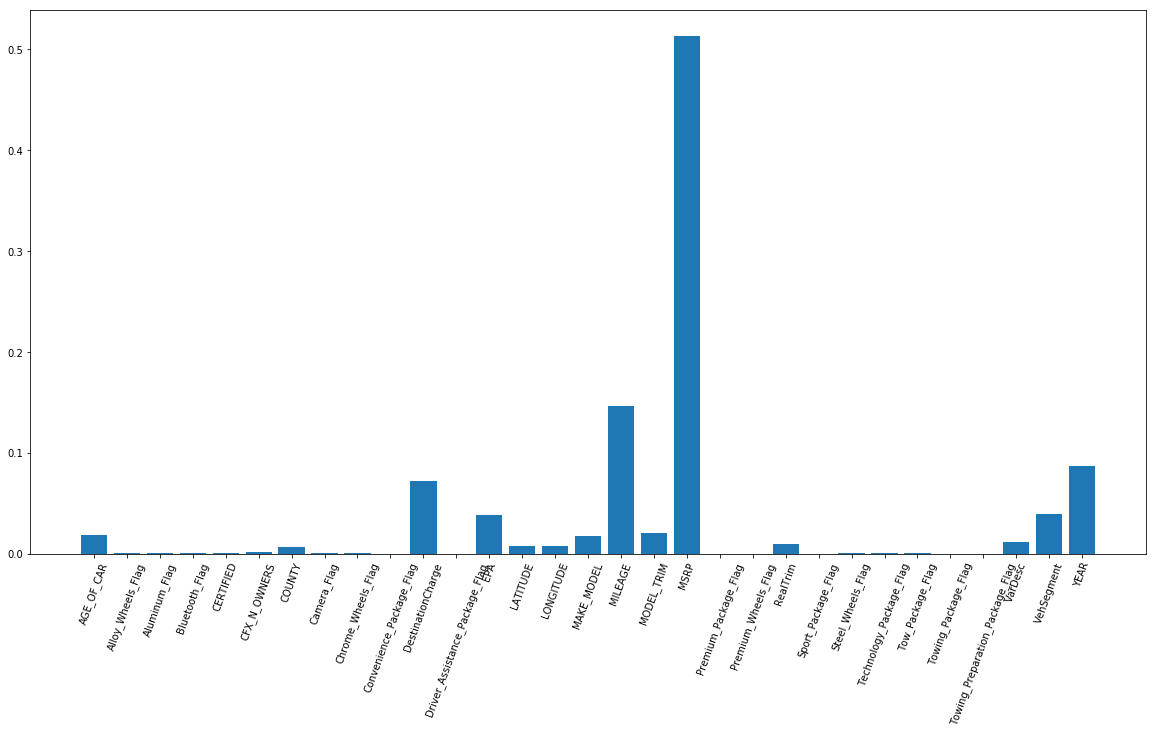

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
print(list(X_valid))
print()
print(len(rf.feature_importances_))
print(rf.feature_importances_)

plt.figure(figsize=[20,10])
plt.bar(list(X_valid),rf.feature_importances_)
plt.xticks(rotation=70)
plt.show()

Get the standard deviation of different price points
Build a polynomial regression equation of standard deviations


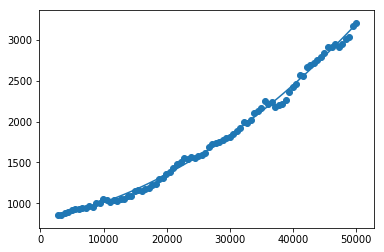

In [12]:
from sklearn.linear_model import LinearRegression
diff_price_points = np.linspace(500,50000,int(45000/500))
pred_all = result_df.pred.values
y_all = result_df.true.values
print('Get the standard deviation of different price points')
se_of_pp = list()
for i in diff_price_points:
    low_bound = i-1000
    upp_bound = i+1000
    group_prices = pred_all[np.where(((y_all > low_bound) & (y_all < upp_bound)))]
    q97, q03 = np.percentile(group_prices, [97 , 3])
    group_prices = group_prices[(group_prices < q97) & (group_prices > q03)]

    se_1 = np.std(group_prices)
    se_of_pp.append(se_1)

est_se_df = pd.DataFrame({'pricepoint':diff_price_points, 'se':se_of_pp})

est_se_df = est_se_df.iloc[4:,]

print('Build a polynomial regression equation of standard deviations')

new_set = est_se_df.copy()
new_set_x = new_set.drop('se', axis = 1)
new_set_x['pp2'] = np.square(new_set_x.pricepoint)
new_set_y = new_set['se'].values
lr = LinearRegression() #fit_intercept=False
lr.fit(new_set_x, new_set_y)

pred_lr = lr.predict(new_set_x)
plt.plot(new_set_x.pricepoint.values, pred_lr)
plt.scatter(new_set_x.pricepoint.values, new_set_y)
plt.show()

(0.9811632025854745, 0.0)


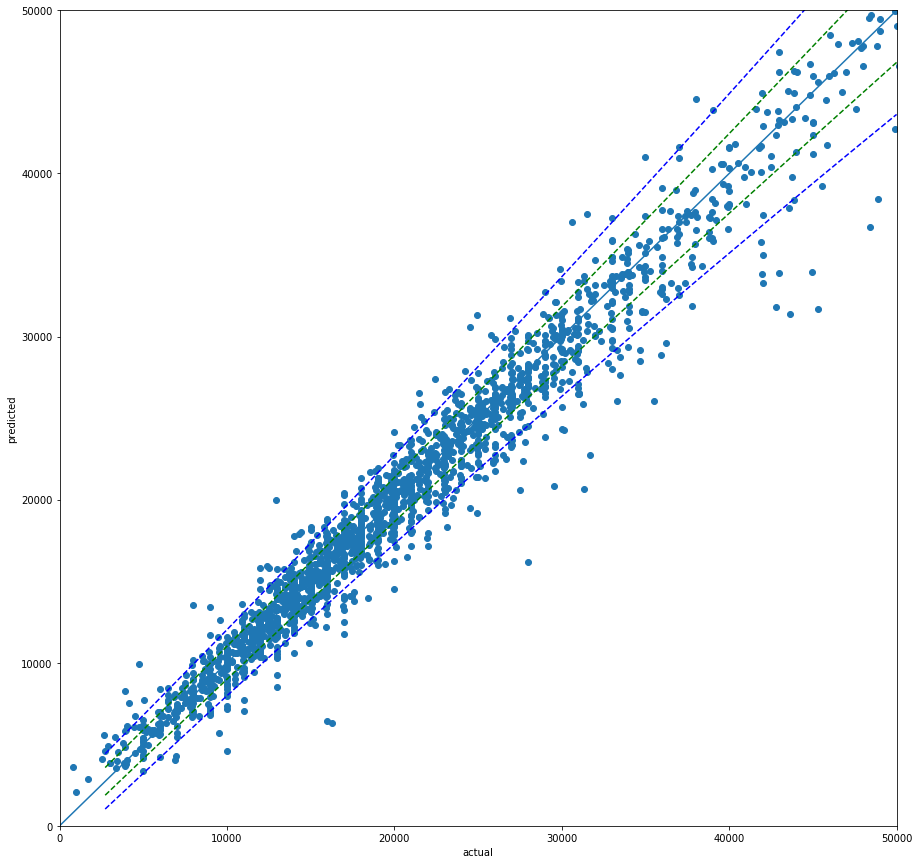

In [13]:
from scipy.stats import pearsonr
y_test = y_all
preds = pred_all
print(pearsonr(y_test, np.squeeze(preds)))
rand_inds = random.sample(range(y_test.shape[0]), 2000)
x_tests = y_test[rand_inds]
y_tests = np.squeeze(preds)[rand_inds]



###
def color_set(x):
    pred_x = lr.predict(x)
    
#color_def = np.where(((true_pred_ratio >= 2)),'red','black')


plt.figure(figsize=(15,15))
plt.scatter(x_tests, y_tests)

#plot smoothed s.d.
plt.plot(new_set.pricepoint, new_set.pricepoint+pred_lr,'g--')
plt.plot(new_set.pricepoint, new_set.pricepoint-pred_lr,'g--')
plt.plot(new_set.pricepoint, new_set.pricepoint+2*pred_lr,'b--')
plt.plot(new_set.pricepoint, new_set.pricepoint-2*pred_lr,'b--')

plt.xlim(0,50000)
plt.ylim(0,50000)
plt.plot(range(50000),range(50000))
plt.xlabel('actual')
plt.ylabel('predicted')

plt.show()

In [14]:
import gc

gc.collect()

10127

In [ ]:
from sklearn.model_selection import KFold

def get_all_predictions(dat_rf, df, y):
    #5 fold cv basically
    
    n_rows = df.shape[0]
    kf = KFold(5)
    store_new_df = pd.DataFrame()
    
    for train_ind, val_ind in kf.split(df):
        rf = RandomForestRegressor(n_estimators = 32, max_features = 0.5, max_depth = 50, n_jobs=16, verbose= 1) # best gridcross score
        X_train, X_valid = df.iloc[train_id],df.iloc[valid_id]
        y_train, y_valid = y[train_id], y[valid_id]
        raw_valid = dat_rf.iloc[valid_id]
        
        rf.fit(X_train, y_train) #%prun 
        preds = rf.predict(X_valid)
        raw_valid['Predicted_Price'] = preds
        
        # get some printouts
        list_of_ranges = [(4000,8000),(8000,10000),(10000,15000),(15000,25000),(25000,35000),(35000,1000000)]
        for i in list_of_ranges:
            lower_ = i[0]
            upper_ = i[1]

            print('MAE for price range $' + str(lower_) + '-$' + str(upper_) + ':')

            condition_1 = (y_valid <= upper_)
            condition_2 = (y_valid >= lower_)
            cond_pred = np.squeeze(preds[condition_1 & condition_2])
            cond_true = y_valid[condition_1 & condition_2]
            print(np.mean(np.abs(cond_pred - cond_true)))
            temp_ = float(cond_true.shape[0])/y_valid.shape[0]
            print('ratio of cars in this range: ' + str(temp_))
            print(' ')
        
        raw_valid['PRICE_RATIO'] = (raw_valid.Predicted_Price.values-raw_valid.PRICE.values)/raw_valid.PRICE.values
        store_new_df = store_new_df.append(raw_valid, ignore_index = True)
    
        

In [15]:
def mark_good_deal(x,y,lr):

    temp_pd = pd.DataFrame({'pricepoint': x, 'pp2': np.square(x)}, columns=['pricepoint','pp2'], index = [0])
    #print(temp_pd)
    pred_x = lr.predict(temp_pd)
    pred_x = float(pred_x)
    if y > x + 2*pred_x:
        return 'Great Deal'
    elif y > x + pred_x:
        return 'Good Deal'
    elif y < x - 2*pred_x:
        return 'Poor Deal'
    elif y < x - pred_x:
        return 'Bad Deal'
    else:
        return 'Okay'
    
def parallel_mark_good(subset_dat,lr):
    return subset_dat.apply(lambda x: mark_good_deal(x.iloc[0],x.iloc[1],lr), axis = 1)


def parallelize_apply_2(data, func,lr):
    data_split = np.array_split([i for i in range(data.shape[0])], 16)
    asdf = Parallel(n_jobs = 16)(delayed(func)(data.iloc[data_split[i],:],lr) for i in range(16))
    to_return = pd.concat(asdf)
    return to_return


#result_df['Deal'] = result_df[['pred','true']].apply(lambda x: mark_good_deal(x.iloc[1], x.iloc[0], lr), axis = 1)
result_df['Deal'] = parallelize_apply_2(result_df[['true','pred']], parallel_mark_good, lr)

result_df.head()

,pred,true,LISTING_ID,Deal
0,11917.093750,10495.0,1735683020,Good Deal
1,32345.406250,28987.0,1735629983,Good Deal
2,6612.671875,5490.0,1735683014,Good Deal
3,23324.921875,22990.0,1735682922,Okay
4,26873.687500,26894.0,1735682848,Okay


In [16]:
#result_df['LOCATION'] = raw_valid['CITY'].astype(str).values + ' ' + raw_valid['STATE'].astype(str).values
result_df['MILEAGE'] = raw_valid['MILEAGE'].values
result_df['MAKE_MODEL'] = raw_valid['MAKE_MODEL'].astype(str).values# + ' ' + raw_valid['RealTrim'].astype(str).values
result_df['MAKE'] = raw_valid['MAKE'].values
result_df['TRIM'] = raw_valid['RealTrim'].values
result_df['YEAR'] = raw_valid['YEAR'].astype(int).values
result_df['FULL_CAR'] = result_df['YEAR'].astype(str) + ' ' + result_df['MAKE_MODEL'].astype(str)
result_df['PRICE_RATIO'] = (result_df.true.values-result_df.pred.values)/result_df.pred.values
result_df['VIN'] = raw_valid['VIN'].values
result_df['MSRP'] = raw_valid['MSRP'].values
result_df['COUNTY'] = raw_valid.COUNTY.values
result_df['CFX_N_OWNERS'] = raw_valid.CFX_N_OWNERS.values
result_df = result_df[['LISTING_ID','FULL_CAR','MILEAGE','pred','true','MSRP','PRICE_RATIO','Deal','YEAR','MAKE_MODEL','MAKE','TRIM','VIN','COUNTY','CFX_N_OWNERS']]
#'LOCATION',
result_df.head()

,LISTING_ID,FULL_CAR,MILEAGE,pred,true,MSRP,PRICE_RATIO,Deal,YEAR,MAKE_MODEL,MAKE,TRIM,VIN,COUNTY,CFX_N_OWNERS
0,1735683020,2014 chevrolet malibu,66218.0,11917.093750,10495.0,22340.0,-0.119332,Good Deal,2014,chevrolet malibu,chevrolet,1ls,1G11B5SL0EF241699,madison county,2 Owners
1,1735629983,2017 genesis g80,37280.0,32345.406250,28987.0,41400.0,-0.103829,Good Deal,2017,genesis g80,genesis,3.8,KMHGN4JE5HU176348,bexar county,CARFAX 1-Owner
2,1735683014,2010 ford fusion,113119.0,6612.671875,5490.0,21225.0,-0.169776,Good Deal,2010,ford fusion,ford,se,3FAHP0HA0AR320664,fayette county,2 Owners
3,1735682922,2017 nissan frontier,5477.0,23324.921875,22990.0,24100.0,-0.014359,Okay,2017,nissan frontier,nissan,s,1N6DD0ER0HN741807,bradley county,CARFAX 1-Owner
4,1735682848,2016 jeep grand cherokee,9843.0,26873.687500,26894.0,32295.0,0.000756,Okay,2016,jeep grand cherokee,jeep,laredo,1C4RJFAG5GC498322,sarpy county,CARFAX 1-Owner


In [17]:
result_df.to_csv('/home/bsong/result_df_to_compare_cargurus.csv', index = False)

In [18]:
list_of_vins = result_df.VIN.values
pickle.dump(list_of_vins, open('/home/bsong/vins_to_check.pkl','wb'))

In [46]:
## find reason for poor deals

result_df.sort_values('PRICE_RATIO',ascending=False).head(30)


,LISTING_ID,FULL_CAR,MILEAGE,pred,true,MSRP,PRICE_RATIO,Deal,YEAR,MAKE_MODEL,MAKE,TRIM,VIN,COUNTY,CFX_N_OWNERS,DIFF
415330,1739472255,2004 dodge neon,160431.0,2932.203125,99995.0,15800.0,33.102344,Poor Deal,2004,dodge neon,dodge,sxt,1B3ES56C94D629254,berks county,missing,-97062.796875
91047,1736732360,2003 mazda tribute,208435.0,4279.968750,99999.0,24630.0,22.364423,Poor Deal,2003,mazda tribute,mazda,es v6,4F2CZ96143KM06220,boone county,missing,-95719.031250
567612,1740689647,2008 mitsubishi galant,150785.0,5150.296875,99999.0,19999.0,18.416162,Poor Deal,2008,mitsubishi galant,mitsubishi,de,4A3AB26F48E035092,blue earth county,missing,-94848.703125
340755,1738390364,2006 ford taurus,233067.0,5575.453125,99999.0,22980.0,16.935583,Poor Deal,2006,ford taurus,ford,sel,1FAFP56U66A205781,blue earth county,missing,-94423.546875
331714,1738369005,2000 bmw 3 series,176687.0,5984.687500,99999.0,34990.0,15.709143,Poor Deal,2000,bmw 3 series,bmw,ci,WBABR3344YEB39027,marshall county,missing,-94014.312500
523658,1740295260,2004 chrysler pt cruiser,160010.0,6086.734375,99999.0,17490.0,15.429007,Poor Deal,2004,chrysler pt cruiser,chrysler,base,3C4FY48B94T334472,stearns county,missing,-93912.265625
87409,1736693430,2005 chevrolet monte carlo,132088.0,6367.500000,99995.0,28355.0,14.703965,Poor Deal,2005,chevrolet monte carlo,chevrolet,supercharged ss,2G1WZ151259291906,bexar county,CARFAX 1-Owner,-93627.500000
341090,1738391811,2005 ford ranger,135378.0,7767.421875,99999.0,21215.0,11.874156,Poor Deal,2005,ford ranger,ford,xl,1FTYR15E45PA43466,stearns county,missing,-92231.578125
477615,1739901808,2005 mazda mpv,169300.0,8027.750000,99999.0,22940.0,11.456666,Poor Deal,2005,mazda mpv,mazda,lx,JM3LW28A550547994,blue earth county,missing,-91971.250000
521338,1740325051,2014 dodge dart,931500.0,8875.515625,100000.0,18595.0,10.266951,Poor Deal,2014,dodge dart,dodge,sxt,1C3CDFBBXED673059,boone county,2 Owners,-91124.484375


In [50]:
result_df[(result_df.true.values > result_df.MSRP.values) & (result_df.Deal == 'Poor Deal') & (result_df.PRICE_RATIO < 1)].sort_values('PRICE_RATIO',ascending=False).head(20)

,LISTING_ID,FULL_CAR,MILEAGE,pred,true,MSRP,PRICE_RATIO,Deal,YEAR,MAKE_MODEL,MAKE,TRIM,VIN,COUNTY,CFX_N_OWNERS,DIFF
561051,1740671095,2010 nissan versa,69208.0,7011.984375,13998.0,13400.0,0.996297,Poor Deal,2010,nissan versa,nissan,1.8s,3N1BC1CP9AL421592,ramsey county,missing,-6986.015625
22028,1735878467,2014 mercedes-benz m-class,58006.0,27628.765625,55135.0,50290.0,0.995565,Poor Deal,2014,mercedes-benz m-class,mercedes-benz,base,4JGDA5HB8EA386083,cuyahoga county,2 Owners,-27506.234375
274564,1737968132,2016 ford escape,84936.0,17359.687500,34575.0,31745.0,0.991683,Poor Deal,2016,ford escape,ford,titanium,1FMCU9J9XGUB57679,kalamazoo county,CARFAX 1-Owner,-17215.312500
605452,1741070218,2016 ford fusion,41773.0,15198.531250,30210.0,24320.0,0.987692,Poor Deal,2016,ford fusion,ford,se,3FA6P0HD5GR186552,st. charles county,CARFAX 1-Owner,-15011.468750
66656,1736493999,2014 cadillac ats,14.0,21930.828125,43585.0,39095.0,0.987385,Poor Deal,2014,cadillac ats,cadillac,2.0l turbo luxury,1G6AB5RX7E0176386,scott county,missing,-21654.171875
546720,1740652295,1996 porsche 911,65904.0,75821.015625,149980.0,63750.0,0.978080,Poor Deal,1996,porsche 911,porsche,carrera,WP0AC2999TS375189,orange county,3 Owners,-74158.984375
244407,1737585958,2016 ford f-150,23434.0,37915.953125,75000.0,36565.0,0.978059,Poor Deal,2016,ford f-150,ford,xl,1FTEW1EFXGFA19234,garvin county,CARFAX 1-Owner,-37084.046875
399403,1739128279,2006 nissan 350z,28857.0,15084.343750,29800.0,27650.0,0.975558,Poor Deal,2006,nissan 350z,nissan,base,JN1AZ34D36M300211,dupage county,2 Owners,-14715.656250
66381,1736492790,2015 nissan altima,10.0,15140.828125,29888.0,22300.0,0.974000,Poor Deal,2015,nissan altima,nissan,2.5,1N4AL3AP5FN867582,atlantic county,missing,-14747.171875
65797,1736492459,2013 nissan altima,12.0,12513.734375,24692.0,21760.0,0.973192,Poor Deal,2013,nissan altima,nissan,2.5,1N4AL3AP9DC198323,rutherford county,CARFAX 1-Owner,-12178.265625


{'Great Deal': 'blue', 'Good Deal': 'green', 'Poor Deal': 'red', 'Okay': 'yellow', 'Bad Deal': 'orange'}
{'Great Deal': 'blue', 'Good Deal': 'green', 'Poor Deal': 'red', 'Okay': 'yellow', 'Bad Deal': 'orange'}


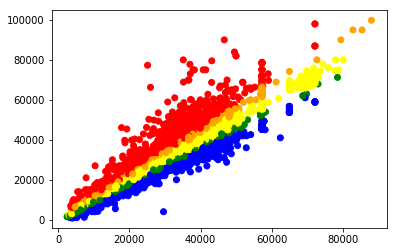

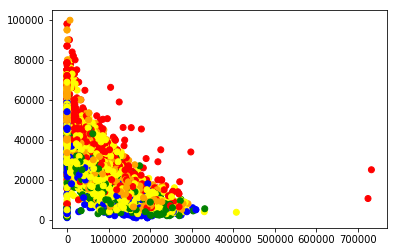

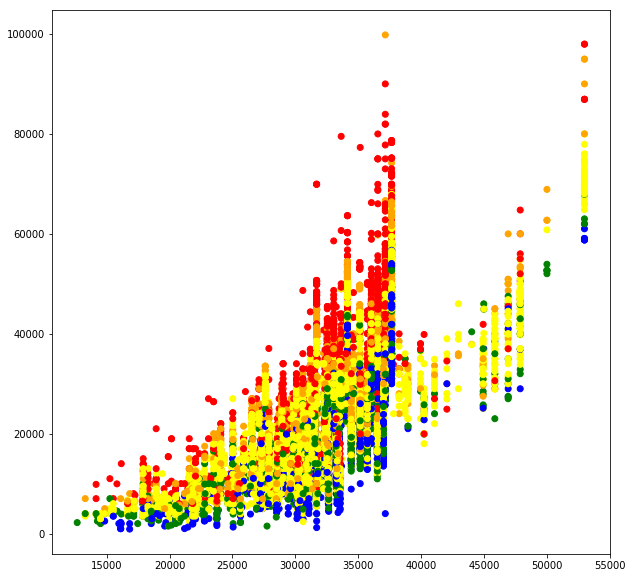

In [19]:
ford_f150_= result_df[(result_df.MAKE_MODEL == 'ford f-150')].copy()
%matplotlib inline
colors = ['orange','green','blue','yellow','red']#np.linspace(0, 1, 5)
colordict = dict(zip(np.unique(ford_f150_.Deal), colors))  
print(colordict)
ford_f150_['Colors'] = ford_f150_.Deal.apply(lambda x: colordict[x])
print(colordict)
plt.figure()
plt.scatter(ford_f150_.pred.values, ford_f150_.true.values, c = ford_f150_.Colors.values)
plt.show()
plt.scatter(ford_f150_.MILEAGE.values, ford_f150_.true.values,c = ford_f150_.Colors.values)
plt.show()
plt.figure(figsize=(10,10))
plt.scatter(ford_f150_.MSRP.values, ford_f150_.true.values,c = ford_f150_.Colors.values)
plt.show()

<IPython.core.display.Javascript object>


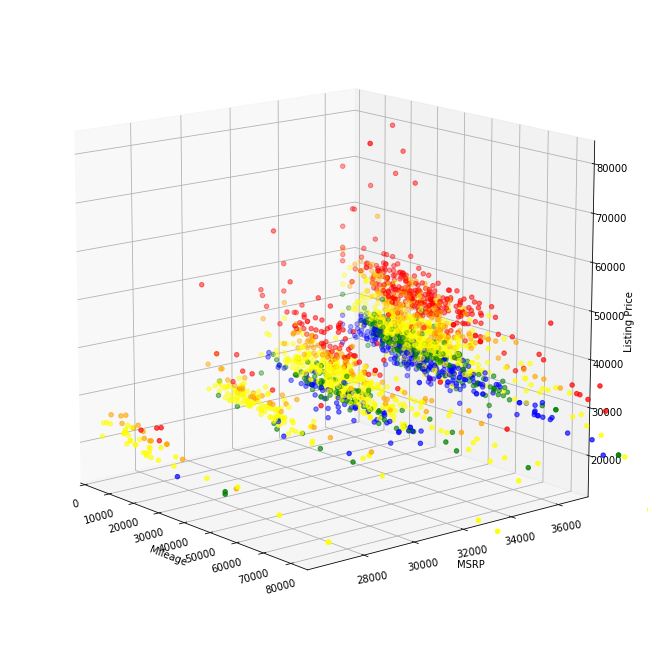

Text(0.5,0,'Listing Price')

In [22]:
from mpl_toolkits.mplot3d import Axes3D
import sys 
%matplotlib notebook
fig = plt.figure(figsize = (9,9))
ax = Axes3D(fig)
temp_ = ford_f150_[(ford_f150_.YEAR == 2016)]
ax.scatter(temp_.MILEAGE.values,temp_.MSRP.values, temp_.true.values, c = temp_.Colors.values)
max_lim_mileage = np.percentile(temp_.MILEAGE.values, 99)
ax.set_xlim(0,max_lim_mileage)
ax.set_xlabel('Mileage')
plt.xticks(rotation=15)
ax.set_ylabel('MSRP')
plt.yticks(rotation=10)
ax.set_zlabel('Listing Price')

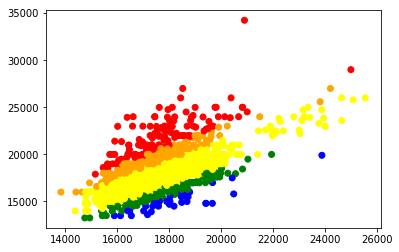

(0.6126763079589254, 7.745905706904346e-220)


In [26]:
%matplotlib inline
plt.scatter(temp_.pred.values, temp_.true.values, c = temp_.Colors.values)
plt.show()
print(pearsonr(temp_.true, temp_.pred))

In [31]:
temp_[(temp_.Deal == 'Poor Deal') & (temp_.MILEAGE < 30000)].sort_values('PRICE_RATIO',ascending = False).head(50)

,LISTING_ID,FULL_CAR,MILEAGE,pred,true,MSRP,PRICE_RATIO,Deal,YEAR,MAKE_MODEL,MAKE,TRIM,VIN,COUNTY,CFX_N_OWNERS,Colors
330452,1736802815,2017 toyota camry,22172.0,18518.640625,26999.0,23070.0,0.457936,Poor Deal,2017,toyota camry,toyota,le,4T1BF1FKXHU642425,el paso county,CARFAX 1-Owner,red
51455,1734291295,2017 toyota camry,9400.0,17613.468750,24988.0,23070.0,0.418687,Poor Deal,2017,toyota camry,toyota,le,4T1BF1FKXHU658463,bristol county,CARFAX 1-Owner,red
214177,1735503499,2017 toyota camry,7776.0,18436.328125,25999.0,23070.0,0.410205,Poor Deal,2017,toyota camry,toyota,le,4T1BF1FKXHU777467,escambia county,NaN,red
183267,1735448429,2017 toyota camry,26659.0,18114.125000,24999.0,23070.0,0.380083,Poor Deal,2017,toyota camry,toyota,le,4T1BF1FK2HU736184,sullivan county,CARFAX 1-Owner,red
132679,1735052180,2017 toyota camry,16661.0,17947.390625,24755.0,23070.0,0.379309,Poor Deal,2017,toyota camry,toyota,le,4T1BF1FK2HU654441,thomas county,CARFAX 1-Owner,red
102180,1734684450,2017 toyota camry,10458.0,17433.562500,23999.0,23070.0,0.376598,Poor Deal,2017,toyota camry,toyota,le,4T1BF1FK4HU376772,washington county,NaN,red
208196,1735485119,2017 toyota camry,13888.0,17445.953125,23995.0,23070.0,0.375391,Poor Deal,2017,toyota camry,toyota,le,4T1BF1FK9HU292835,ocean county,CARFAX 1-Owner,red
547902,1738354662,2017 toyota camry,14598.0,16979.000000,22995.0,23070.0,0.354320,Poor Deal,2017,toyota camry,toyota,le,4T1BF1FK7HU654483,rockingham county,CARFAX 1-Owner,red
118980,1734703096,2017 toyota camry,18800.0,17927.421875,23946.0,23070.0,0.335719,Poor Deal,2017,toyota camry,toyota,le,4T1BF1FK9HU359627,bernalillo county,CARFAX 1-Owner,red
512623,1737982867,2017 toyota camry,18761.0,17265.234375,22990.0,23070.0,0.331578,Poor Deal,2017,toyota camry,toyota,le,4T1BF1FK2HU327635,bucks county,CARFAX 1-Owner,red


In [ ]:
list_camry_vins = temp_.VIN.values

In [ ]:
pickle.dump(list_camry_vins,open('/home/bsong/camry_vins.pkl','wb'))

In [37]:
pickle.dump(temp_,open('/home/bsong/ford_f150_for_3dplot.pkl','wb'))

In [ ]:
np.percentile(temp_.MILEAGE.values, 97)

In [ ]:
result_df[result_df.LISTING_ID.isin(['1707877939','1709207838','1707014138','1707020992','1707878576','1708843911'])].iloc[[3,5,0,1,2,4],:]

In [ ]:
result_df[result_df.VIN == '4T1BF1FK4FU051553']

In [ ]:
cond1 = raw_valid.MILEAGE.between(30000,45000)
cond2 = raw_valid.MAKE_MODEL == 'toyota camry'
#cond3 = raw_valid.RealTrim == "se"
cond4 = raw_valid.YEAR == 2015
sub_ = raw_valid[cond1 & cond2 & cond4]
Counter(sub_.RealTrim.values).most_common()

In [ ]:
dat_rf.shape#[(dat_rf.MAKE_MODEL == 'toyota camry') & (dat_rf.RealTrim == 'se')].YEAR.max()

In [38]:
deal_by_make = result_df.pivot_table(index = 'MAKE', columns = 'Deal', values = 'LISTING_ID', aggfunc= 'count')
deal_by_make = deal_by_make[['Poor Deal','Bad Deal','Okay','Good Deal','Great Deal']]
freqs_deal_by_make = deal_by_make.divide(np.sum(deal_by_make, axis = 1).values, axis = 0)
freqs_deal_by_make

Deal,Poor Deal,Bad Deal,Okay,Good Deal,Great Deal
MAKE,,,,,
acura,0.026743,0.108571,0.770743,0.070857,0.023086
alfa romeo,0.028169,0.140845,0.591549,0.140845,0.098592
audi,0.040625,0.128490,0.665476,0.116845,0.048564
bmw,0.038415,0.119273,0.655186,0.134617,0.052508
buick,0.044729,0.128393,0.721358,0.078276,0.027244
cadillac,0.035344,0.124619,0.704042,0.098111,0.037883
chevrolet,0.050227,0.157903,0.691118,0.075095,0.025657
chrysler,0.048788,0.137133,0.694528,0.088858,0.030694
dodge,0.066923,0.175360,0.644649,0.081407,0.031661


In [23]:
full_car_deals = result_df.pivot_table(index='FULL_CAR',columns = 'Deal', values = "LISTING_ID", aggfunc='count')
full_car_deals = full_car_deals[['Poor Deal','Bad Deal','Okay','Good Deal','Great Deal']]
freq_full_car_deals = full_car_deals.divide(np.sum(full_car_deals, axis = 1).values, axis = 0)
full_car_deals['Total'] = full_car_deals.apply(np.nansum, axis =1)
full_car_deals

Deal,Poor Deal,Bad Deal,Okay,Good Deal,Great Deal,Total
FULL_CAR,,,,,,
1992 acura nsx,1.0,NaN,NaN,NaN,NaN,1.0
1992 buick lesabre,NaN,NaN,NaN,2.0,NaN,2.0
1992 buick park avenue,NaN,NaN,NaN,1.0,NaN,1.0
1992 buick roadmaster,1.0,1.0,NaN,1.0,1.0,4.0
1992 cadillac allante,NaN,NaN,NaN,1.0,NaN,1.0
1992 cadillac brougham,NaN,NaN,1.0,NaN,NaN,1.0
1992 cadillac eldorado,NaN,NaN,2.0,NaN,NaN,2.0
1992 cadillac fleetwood,NaN,NaN,NaN,NaN,1.0,1.0
1992 chevrolet 1500,NaN,NaN,1.0,2.0,1.0,4.0


In [28]:
cond1 = full_car_deals['Poor Deal'].notnull()
cond2 = full_car_deals['Bad Deal'].notnull()
cond3 = full_car_deals['Okay'].notnull()
cond4 = full_car_deals['Good Deal'].notnull()
cond5 = full_car_deals['Great Deal'].notnull()
cond6 = full_car_deals['Total'] > 100 
#cond7 = full_car_deals['Total'] > 30
no_na_full_car_deals = full_car_deals[cond1 & cond2 & cond3 & cond4 & cond5 & cond6]

cars_to_verify_with = no_na_full_car_deals.index.values
cars_to_verify_with = [str(i) for i in cars_to_verify_with]

result_df_verify = result_df.copy()
result_df_verify = result_df_verify[result_df_verify.FULL_CAR.astype(str).isin(cars_to_verify_with)]
#result_df_verify = result_df_verify[result_df_verify.PRICE_RATIO < 1]

In [29]:
verify_pt = result_df_verify.pivot_table(index = 'FULL_CAR', columns = 'Deal', values = 'PRICE_RATIO', aggfunc='mean') #,'true','PRICE_RATIO'
verify_pt = verify_pt[['Poor Deal','Bad Deal','Okay','Good Deal','Great Deal']]
verify_pt['Total Cars'] = result_df_verify.pivot_table(index = 'FULL_CAR', values = 'LISTING_ID', aggfunc='count')

some_out_mean = result_df_verify.pivot_table(index = 'Deal', values = 'PRICE_RATIO', aggfunc = 'mean')
some_out_mean = some_out_mean.loc[['Great Deal','Good Deal','Okay','Bad Deal','Poor Deal']]
some_out_std = result_df_verify.pivot_table(index = 'Deal', values = 'PRICE_RATIO', aggfunc = 'std')
some_out_std = some_out_std.loc[['Great Deal','Good Deal','Okay','Bad Deal','Poor Deal']]

print(some_out_mean, some_out_std)
#print(verify_pt.mean(), verify_pt.std())
#verify_pt.head(30)

            PRICE_RATIO
Deal                   
Great Deal    -0.182406
Good Deal     -0.097137
Okay           0.003559
Bad Deal       0.111397
Poor Deal      0.256971             PRICE_RATIO
Deal                   
Great Deal     0.077794
Good Deal      0.031137
Okay           0.039316
Bad Deal       0.032868
Poor Deal      0.221752


In [ ]:
verify_listing_id = result_df_verify.LISTING_ID.values
pickle.dump(verify_listing_id, open('/home/bsong/verify_listing_id.pkl','wb'))

In [ ]:
verify_pt.sort_values('Poor Deal',ascending=False)

In [ ]:
result_df[result_df.FULL_CAR == 'hyundai tucson sel'].sort_values('true')

In [ ]:
# investigate poor deals
poor_df = result_df[result_df.Deal == 'Poor Deal'].copy()
poor_df = poor_df[poor_df.FULL_CAR.astype(str).isin(cars_to_verify_with)]
poor_df.head(20)

In [ ]:

toy_sienna_= result_df[(result_df.FULL_CAR == '2013 toyota sienna l v6 7 passenger')]

colors = ['orange','blue','green','yellow','red']#np.linspace(0, 1, 5)
colordict = dict(zip(np.unique(toy_sienna_.Deal), colors))  
print(colordict)
toy_sienna_['Colors'] = toy_sienna_.Deal.apply(lambda x: colordict[x])
print(colordict)
plt.scatter(toy_sienna_.pred.values, toy_sienna_.true.values, c = toy_sienna_.Colors.values)
plt.show()
plt.scatter(toy_sienna_.MILEAGE.values, toy_sienna_.true.values,c = toy_sienna_.Colors.values)
plt.show()

In [ ]:
raw_valid.head()

In [ ]:
plt.hist(poor_df[poor_df.true < 100000].true,bins = 30)
plt.show()

In [30]:
low_car_count_deals = full_car_deals[(full_car_deals['Total'] < 100) & (full_car_deals['Total'] >= 30)] #(full_car_deals['Total'] < 100) & 
low_car_verify_list = [str(i) for i in low_car_count_deals.index.values]
low_df_verify = result_df.copy()
low_df_verify = low_df_verify[low_df_verify.FULL_CAR.astype(str).isin(low_car_verify_list)]
low_verify_pt = low_df_verify.pivot_table(index = 'FULL_CAR', columns = 'Deal', values = 'PRICE_RATIO', aggfunc='mean') #,'true','PRICE_RATIO'
low_verify_pt = low_verify_pt[['Poor Deal','Bad Deal','Okay','Good Deal','Great Deal']]
low_verify_pt['Total Cars'] = low_df_verify.pivot_table(index = 'FULL_CAR', values = 'LISTING_ID', aggfunc='count')

some_out_mean = low_df_verify.pivot_table(index = 'Deal', values = 'PRICE_RATIO', aggfunc = 'mean')
some_out_mean = some_out_mean.loc[['Poor Deal','Bad Deal','Okay','Good Deal','Great Deal']]
some_out_std = low_df_verify.pivot_table(index = 'Deal', values = 'PRICE_RATIO', aggfunc = 'std')
some_out_std = some_out_std.loc[['Poor Deal','Bad Deal','Okay','Good Deal','Great Deal']]

print(some_out_mean, some_out_std)
low_verify_pt.head(30)

            PRICE_RATIO
Deal                   
Poor Deal      0.358558
Bad Deal       0.141380
Okay           0.000919
Good Deal     -0.135555
Great Deal    -0.264200             PRICE_RATIO
Deal                   
Poor Deal      0.484490
Bad Deal       0.062856
Okay           0.053772
Good Deal      0.073724
Great Deal     0.140806


Deal,Poor Deal,Bad Deal,Okay,Good Deal,Great Deal,Total Cars
FULL_CAR,,,,,,
1996 chevrolet corvette,0.719066,0.147881,-0.021458,-0.095561,-0.216721,30
1997 ford f-150,0.481694,0.316931,0.013596,-0.293038,-0.391190,42
1998 chevrolet corvette,0.179995,0.125617,0.006127,-0.091644,-0.176026,31
1998 ford f-150,0.472101,0.241369,-0.012995,-0.255496,-0.445804,42
1999 chevrolet corvette,0.268969,0.121226,-0.001538,-0.127956,-0.230535,33
1999 chevrolet silverado 1500,0.374149,0.256129,0.015199,-0.206606,-0.357825,34
1999 ford f-150,0.419023,0.155553,0.004210,-0.249027,NaN,35
1999 ford ranger,0.440788,0.358564,-0.034776,-0.242246,NaN,38
1999 toyota camry,1.336354,0.425813,-0.058373,-0.389229,-0.494703,32


In [ ]:
a = result_df.sort_values('PRICE_RATIO', ascending=False)
a

In [ ]:
#raw_valid[(raw_valid.MAKE_MODEL == 'toyota highlander') & (raw_valid.RealTrim == 'le')].sort_values('PRICE')
raw_valid[raw_valid.LISTING_ID == 1707032099]

In [ ]:
raw_valid.head()

In [ ]:
rand_int = random.sample(range(result_df.shape[0]), 20)
random_result_df = result_df.iloc[rand_int,:]
random_result_df.reset_index(inplace=True)
random_result_df.drop('index',axis=1,inplace=True)
random_result_df

In [ ]:
a = random_result_df.head(6).copy()
a['LISTING_ID'] = [str(int(i)) for i in a.LISTING_ID]
a

In [ ]:
dat_.loc[1708843911]

In [31]:
a = Counter(result_df.Deal).most_common()
a_c = [i for _,i in a]
a_name = [i for i,_ in a]
a_c2 = a_c / sum(np.array(a_c))
pd.DataFrame({'name': a_name, 'count': a_c, 'ratio':a_c2}, columns = ['name','count','ratio'])

,name,count,ratio
0,Okay,459264,0.670753
1,Bad Deal,92443,0.135013
2,Good Deal,68365,0.099847
3,Poor Deal,38212,0.055808
4,Great Deal,26415,0.038579


In [32]:
def wtf_mae(diffs):
    return np.mean(np.abs(diffs))
def wtf_rmse(diffs):
    return np.sqrt(np.mean(np.square(diffs)))
result_df['DIFF'] = result_df.pred.values - result_df.true.values
all_mae = result_df.pivot_table(index = 'MAKE_MODEL', values = 'DIFF', aggfunc = wtf_mae)
all_rmse = result_df.pivot_table(index = 'MAKE_MODEL', values = 'DIFF', aggfunc = wtf_rmse)

In [ ]:
result_df[result_df['MAKE_MODEL'] == 'acura integra']

In [33]:
all_mae.columns= ['MAE_Generalized']
all_rmse.columns = ['RMSE_Generalized']

In [34]:
mae_f150 = all_mae.loc['ford f-150'].copy()
print(mae_f150)

rmse_f150 = all_rmse.loc['ford f-150'].copy()
print(rmse_f150)


MAE_Generalized    2537.595593
Name: ford f-150, dtype: float64
RMSE_Generalized    3836.617982
Name: ford f-150, dtype: float64


In [35]:
results_general_rf = pd.DataFrame({"MAE_Generalized":all_mae.MAE_Generalized, "RMSE_Generalized": all_rmse.RMSE_Generalized})
results_general_rf.reset_index(inplace=True)
results_general_rf.head()


,MAKE_MODEL,MAE_Generalized,RMSE_Generalized
0,acura cl,848.495908,1101.628361
1,acura ilx,831.992906,1151.624702
2,acura integra,2507.131250,2678.049186
3,acura mdx,1077.889484,1518.876577
4,acura mdx sport hybrid,1801.031250,1831.240051


In [36]:
results_general_rf.to_csv('/home/bsong/General_rf_mae_rmse.csv')

In [37]:
ave_price_makemodel = dat_rf.pivot_table(index='MAKE_MODEL', values = 'PRICE', aggfunc='mean')
ave_price_makemodel.columns = ['Average_price']
ave_price_makemodel.reset_index(inplace=True)

std_price_makemodel = dat_rf.pivot_table(index='MAKE_MODEL', values = 'PRICE', aggfunc='std')
std_price_makemodel.columns = ['StD_price']
std_price_makemodel.reset_index(inplace=True)

count_price_makemodel = dat_rf.pivot_table(index='MAKE_MODEL', values = 'PRICE', aggfunc='count')
count_price_makemodel.columns = ['Count']
count_price_makemodel.reset_index(inplace=True)


In [38]:
results_general_rf = results_general_rf.merge(ave_price_makemodel, left_on='MAKE_MODEL',right_on='MAKE_MODEL', how='inner')
#results_general_rf.drop('MAKE_MODEL', axis = 1 , inplace=True)
results_general_rf = results_general_rf.merge(std_price_makemodel, left_on='MAKE_MODEL', right_on='MAKE_MODEL', how='inner')
results_general_rf = results_general_rf.merge(count_price_makemodel, left_on='MAKE_MODEL', right_on='MAKE_MODEL', how='inner')

In [39]:
#combined_rf_df.MAKE_MODEL.fillna('not_in_test_set',inplace = True)
results_general_rf.RMSE_Generalized.fillna(999999,inplace = True)
results_general_rf.MAE_Generalized.fillna(999999,inplace = True)

In [ ]:
clean_and_predict_rf(dat_rf[dat_rf.MAKE_MODEL == 'acura integra'], rf)

In [ ]:
x = np.array([2722.0625,3948.75,  5056.9375,3749.5625]) 
y = np.array([2250, 3999, 5995, 1988])
np.mean(abs(x-y))

In [ ]:
results_general_rf

In [40]:
combined_rf_df = df_results_individual.merge(results_general_rf, left_on='NAME', right_on='MAKE_MODEL', how = 'left')
combined_rf_df.head()

NameError: name 'df_results_individual' is not defined

In [ ]:
combined_rf_df.to_csv('/home/bsong/combiend_rf_df.csv')

In [43]:
results_general_rf.head(100)

,MAKE_MODEL,MAE_Generalized,RMSE_Generalized,Average_price,StD_price,Count
0,acura cl,848.495908,1101.628361,4228.103448,1840.077007,58
1,acura ilx,831.992906,1151.624702,19377.272727,3574.488842,1617
2,acura integra,2507.131250,2678.049186,4083.230769,2669.873691,13
3,acura mdx,1077.889484,1518.876577,26933.385273,10428.748223,8542
4,acura mdx sport hybrid,1801.031250,1831.240051,52142.000000,3605.018955,19
5,acura nsx,12202.590625,13906.636933,128888.428571,39227.539350,49
6,acura rdx,974.878818,1407.937532,25544.398933,7235.782707,5061
7,acura rl,874.191120,1150.941465,9705.024259,4093.616956,371
8,acura rlx,1816.589764,2402.302436,31882.944056,9479.144299,143
9,acura rlx sport hybrid,7384.187500,9020.519585,41672.583333,14234.624480,12


In [ ]:
# quick analysis on both df
ind_results_rf_df_abridge = df_results_individual[df_results_individual.MAE != 999999].copy()
ave_mae_ind_ = np.sum(ind_results_rf_df_abridge.MAE.values * ind_results_rf_df_abridge.COUNT.values) / np.sum(ind_results_rf_df_abridge.COUNT.values)
ave_rmse_ind_ = np.sum(ind_results_rf_df_abridge.RMSE.values * ind_results_rf_df_abridge.COUNT.values) / np.sum(ind_results_rf_df_abridge.COUNT.values)

print('Quick summary of Random Forest on individual listings (up to ~1700 individual models)')
print(' ')
print('number of models: ' + str(ind_results_rf_df_abridge.shape[0]))
print('number of models under 100 listings: ' + str(df_results_individual.shape[0] - ind_results_rf_df_abridge.shape[0]))
print('average MAE for individual rf (for models with 100+ listings): ' + str(ave_mae_ind_)) #np.mean(ind_results_rf_df_abridge.MAE.values)
#print('average RMSE for individual rf (for models with 100+ listings): ' + str(ave_rmse_ind_)) #np.mean(ind_results_rf_df_abridge.RMSE.values)
print('  ')

gen_res_df_abridge = results_general_rf[results_general_rf.MAE_Generalized != 999999]
ave_mae_gen = np.sum(gen_res_df_abridge.MAE_Generalized.values * gen_res_df_abridge.Count.values) / np.sum(gen_res_df_abridge.Count.values)
ave_rmse_gen = np.sum(gen_res_df_abridge.RMSE_Generalized.values * gen_res_df_abridge.Count.values) / np.sum(gen_res_df_abridge.Count.values)
print('Quick summary of Random Forest using all listings (one model)')
print(' ')
print('number of models: ' + str(gen_res_df_abridge.shape[0]))
print('number of models not in test set (where results were obtained from): ' + str(df_results_individual.shape[0] - gen_res_df_abridge.shape[0]))
print('average MAE for general rf: ' + str(ave_mae_gen)) # np.mean(results_general_rf.MAE_Generalized.values)
#print('average RMSE for general rf: ' + str(ave_rmse_gen)) # np.mean(results_general_rf.RMSE_Generalized.values)
print(' ')

combined_df_abridge = combined_rf_df[(combined_rf_df.MAE != 999999) & (combined_rf_df.MAE_Generalized != 999999)]
ave_mae_ind_ = np.sum(combined_df_abridge.MAE.values * combined_df_abridge.COUNT.values) / np.sum(combined_df_abridge.COUNT.values)
ave_rmse_ind_ = np.sum(combined_df_abridge.RMSE.values * combined_df_abridge.COUNT.values) / np.sum(combined_df_abridge.COUNT.values)
ave_mae_gen = np.sum(combined_df_abridge.MAE_Generalized.values * combined_df_abridge.Count.values) / np.sum(combined_df_abridge.Count.values)
ave_rmse_gen = np.sum(combined_df_abridge.RMSE_Generalized.values * combined_df_abridge.Count.values) / np.sum(combined_df_abridge.Count.values)


print('Quick summary of comparing the two models (Where they both have information)')
print(' ')
print('number of models that have information in both datasets: ' + str(combined_df_abridge.shape[0]))
print('average MAE for individual rf: ' + str(ave_mae_ind_)) #np.mean(combined_df_abridge.MAE.values)
print('average MAE for general rf: ' + str(ave_mae_gen)) #np.mean(combined_df_abridge.MAE_Generalized.values)
#print('average RMSE for individual rf: ' + str(ave_rmse_ind_)) # np.mean(combined_df_abridge.RMSE.values)
#print('average RMSE for general rf: ' + str(ave_rmse_gen)) #np.mean(combined_df_abridge.RMSE_Generalized.values)
print(' ')

right_join_df = combined_rf_df[(combined_rf_df.MAE == 999999) & (combined_rf_df.MAE_Generalized != 999999)]
ave_mae_right = np.sum(right_join_df.MAE_Generalized.values * right_join_df.Count.values) / np.sum(right_join_df.Count.values)

print('Quick summary of Random Forest on all listings of just Make/Model <100 listings')
print(' ')
print('number of models that have <100 listings that are in test set: ' + str(right_join_df.shape[0]))
print('average MAE for <100 listings Make/Model general rf: ' + str(ave_mae_right)) #np.mean(combined_df_abridge.MAE.values)

In [ ]:
right_join_df

In [ ]:
import math
preds_unscaled = np.expm1(preds)

def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(train_x), train_y), rmse(m.predict(test_x), test_y),
                m.score(train_x, train_y), m.score(test_x, test_y)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
'''
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape
    
'''

In [ ]:
print_score(rf)